In [1]:
import sys
sys.path.append('..')
# from src.evo_eq_model import *
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import random
import numpy.random as rnd
# import networkx as nx
# from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
import neo_originations.utils as ut
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so
import scipy.stats as spst

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
sns.set_theme(context='poster')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 15
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30

2024-12-10 16:52:20.635 | INFO     | neo_originations.config:<module>:11 - PROJ_ROOT path is: /Users/dennytrimcev/Dropbox/Work_Main/Thesis/2_chapter


In [3]:
flupredict_to_pango = {"1":"WT",
            "1A":"A",
            "1B":"B",
            "1C":"B.1",
            "1C.2A":"B.1",
            "1C.2A.3A":"B.1",
            "1C.2A.3A.4A":"B.1.427/429",
            "1C.2A.3A.4B":"B.1.351",
            '1C.2A.3A.4C':"B.1.526",
            "1C.2B":"B1.1",
            "1C.2B.3D":"B.1.1.7",
            "1C.2B.3G":"P.1",
            "1C.2B.3J":"BA",
            "1C.2B.3J.4D":"BA.1",
            "1C.2B.3J.4D.5A":"BA.1.1",
            "1C.2B.3J.4E":"BA.2",
            "1C.2B.3J.4E.5B": "BA.2.12.1",
            "1C.2B.3J.4E.5C":"BA.2.75",
            "1C.2B.3J.4E.5C.6A":"BA.2.75.2",
            "1C.2B.3J.4E.5C.6E":"BM.1.1",
            "1C.2B.3J.4E.5C.6I.7C":"CH.1.1",
            "1C.2B.3J.4E.5C.6F":"BN.1",
            "1C.2B.3J.4E.5O":"BA.2.86",
            "1C.2B.3J.4E.5O.6L":"JN.1",
            "1C.2B.3J.4E.5O.6L.7G":"JN.1.1",
            "1C.2B.3J.4E.5O.6L.7H":"JN.1.4",
            "1C.2B.3J.4E.5O.6L.7I":"JN.1.11",
            "1C.2B.3J.4F":"BA.4",
            "1C.2B.3J.4F.5D":"BA.4.6",
            "1C.2B.3J.4G":"BA.5",
            "1C.2B.3J.4G.5E":"BF.7",
            "1C.2B.3J.4G.5F":"BQ.1",
            "1C.2B.3J.4G.5F.6B":"BQ.1.1",
            "1C.2C":"B.1.177",
            "1C.2D":"B.1.1",
            "1C.2D.3E":"B.1.617.1",
            "1C.2D.3F":"B.1.617.2",
            "1C.2A.3I":"B.1.621",
            "1C.2B.3J.4E.5N":"XBB",
            "1C.2B.3J.4E.5N.6J":"XBB.1.5",
            "1C.2B.3J.4E.5N.6J.7F":"JD.1.1",
            "1C.2B.3J.4E.5N.6J.7D":"XBB.1.9",
            "1C.2B.3J.4E.5N.6J.7D.8A":"EG.5.1",
            "1C.2B.3J.4E.5N.6J.7D.8A.9A":"HK.3",
            "1C.2B.3J.4E.5N.6J.7D.8A.9B":"HV.1",
            "1C.2B.3J.4E.5N.6J.7E":"XBB.1.16",
            "1C.2B.3J.4E.5N.6K":"XBB.2.3"}

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

output_folder= project_path+'/reports/figures/'
os.makedirs(output_folder, exist_ok = True)
data_folder = project_path+'/data/'
saves_folder= project_path + '/data/interim/'
self_generated_data = project_path + '/data/processed/'



In [6]:
# global_clade_stats_SARS_CoV_2_folder = project_path+'/data/global_clade_stats_SARS_CoV_2/'
global_clade_stats_SARS_CoV_2_folder = project_path+'/data/external/2024-07-15-data/'

assert os.path.exists(global_clade_stats_SARS_CoV_2_folder)

global_clade_statistics_SARS_CoV_2_World = pd.read_csv(global_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

global_clade_statistics_SARS_CoV_2_World = global_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

driver_mutation_statistics = pd.read_csv(global_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')


reference_date = pd.to_datetime('2020-01-01')
global_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(global_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days

In [7]:
last_date = '2022-12-31'
#/Users/dennytrimcev/Dropbox/Work_Main/neo_originations/data/external/2024-03-04-data
covid_data = pd.read_csv(project_path+'/data/external/2024-03-04-data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World']#.query(f'date < "{last_date}"')

covid_data_World['day_diff'] = (pd.to_datetime(covid_data_World['date']) - reference_date).dt.days

In [8]:
driver_mutation_statistics['Pango_Variant'] = driver_mutation_statistics['Variant'].map(flupredict_to_pango)

syn_set = set([c for c in driver_mutation_statistics.columns if 'syn' in c]) - set([c for c in driver_mutation_statistics.columns if 'RBD' in c or 'weight' in c])
nonsyn_set = [c.split('_')[1] for c in syn_set if 'syn' in c]

driver_mutation_statistics['syn_weight'] = driver_mutation_statistics.apply(lambda x: np.sum([x[gene] for gene in syn_set]), axis=1)
driver_mutation_statistics['nonsyn_weight'] = driver_mutation_statistics.apply(lambda x: np.sum([x[gene] for gene in nonsyn_set]), axis=1)
driver_mutation_statistics['total_weight'] = driver_mutation_statistics.apply(lambda x: x['syn_weight']+x['nonsyn_weight'], axis=1)

In [9]:
global_clade_statistics_SARS_CoV_2_World = pd.merge(global_clade_statistics_SARS_CoV_2_World, driver_mutation_statistics[['Clade','Pango_Variant']], on = 'Clade', how = 'left')


In [10]:
driver_mutation_statistics['Pango_Variant'].unique()

array(['WT', 'B.1.351', 'B.1.617.2', 'P.1', 'B.1.1.7', 'BA', 'BA.1',
       'BA.2', 'BA.5', 'XBB.1.5', 'XBB', 'XBB.2.3', 'XBB.1.9', 'XBB.1.16',
       'EG.5.1'], dtype=object)

In [11]:
# #take clade, max sublineage frequency in first chunk
# summary_first_chunk = global_clade_statistics_SARS_CoV_2_World_first_chunck.groupby('Clade').agg({'Sublineage_Freq':'max'}).reset_index()
# summary_first_chunk = pd.merge(summary_first_chunk, driver_mutation_statistics, left_on='Clade', right_on='Clade', how='left')

# summary_second_chunk = global_clade_statistics_SARS_CoV_2_World_second_chunck.groupby('Clade').agg({'Sublineage_Freq':'max'}).reset_index()
# summary_second_chunk = pd.merge(summary_second_chunk,
# driver_mutation_statistics, left_on='Clade', right_on='Clade', how='left')

def get_summary_chunck_variant(pv):
    global_clade_statistics_SARS_CoV_2_World_chunck = global_clade_statistics_SARS_CoV_2_World.query(f'Pango_Variant == "{pv}"')

    summary_chunck = global_clade_statistics_SARS_CoV_2_World_chunck.groupby('Clade').agg({'Sublineage_Freq':'max'}).reset_index()
    summary_chunck = pd.merge(summary_chunck, driver_mutation_statistics, left_on='Clade', right_on='Clade', how='left')
    return summary_chunck



In [12]:

global_merged_df = pd.merge(global_clade_statistics_SARS_CoV_2_World, driver_mutation_statistics[['Clade', 'Variant', 'syn_weight', 'S_RBD', 'S','total_weight']], on='Clade')

global_time_series_df = global_merged_df.groupby(['Variant', 'day_diff']).agg({
    'Clade_Freq': 'sum'
}).reset_index()

# Rename columns to match the desired output
global_time_series_df.columns = ['Variant', 'day_diff', 'Freq']
global_time_series_df['Pango_Variant'] = global_time_series_df['Variant'].map(flupredict_to_pango)

In [13]:
%load_ext autoreload

In [14]:
summary_chuncks= [get_summary_chunck_variant(pv) for pv in driver_mutation_statistics['Pango_Variant'].unique()]

In [15]:
summary_chuncks[0].Pango_Variant.unique()[0]

'WT'

In [16]:
new_summary_chunk_candidates = [(summary_chuncks[i].Pango_Variant.unique()[0],len(summary_chuncks[i])) for i in range(len(summary_chuncks)) if len(summary_chuncks[i])>1e4]
print(new_summary_chunk_candidates)

new_summary_chuncks= [summary_chuncks[i] for i in range(len(summary_chuncks)) if len(summary_chuncks[i])>1e4]
print(len(summary_chuncks))

#sort by origination time
new_summary_chuncks = np.array(new_summary_chuncks, dtype=object)[np.argsort([new_summary_chuncks[i].Emergence_Time.min() for i in range(len(new_summary_chuncks))])]

[('WT', 66299), ('B.1.617.2', 152906), ('B.1.1.7', 18187), ('BA.1', 17881), ('BA.2', 40618), ('BA.5', 95329), ('XBB.1.5', 22655)]
15


49 82
 2.10 x^0.35 fit for RBD g factor
49 82
Fitting unsuccessful
49 82
Fitting unsuccessful
49 82
 0.11 x^-0.10 fit for RBD g factor
49 82
 3.04 x^0.43 fit for RBD g factor
49 82
 1.40 x^0.26 fit for RBD g factor
49 82
 1.02 x^0.11 fit for RBD g factor


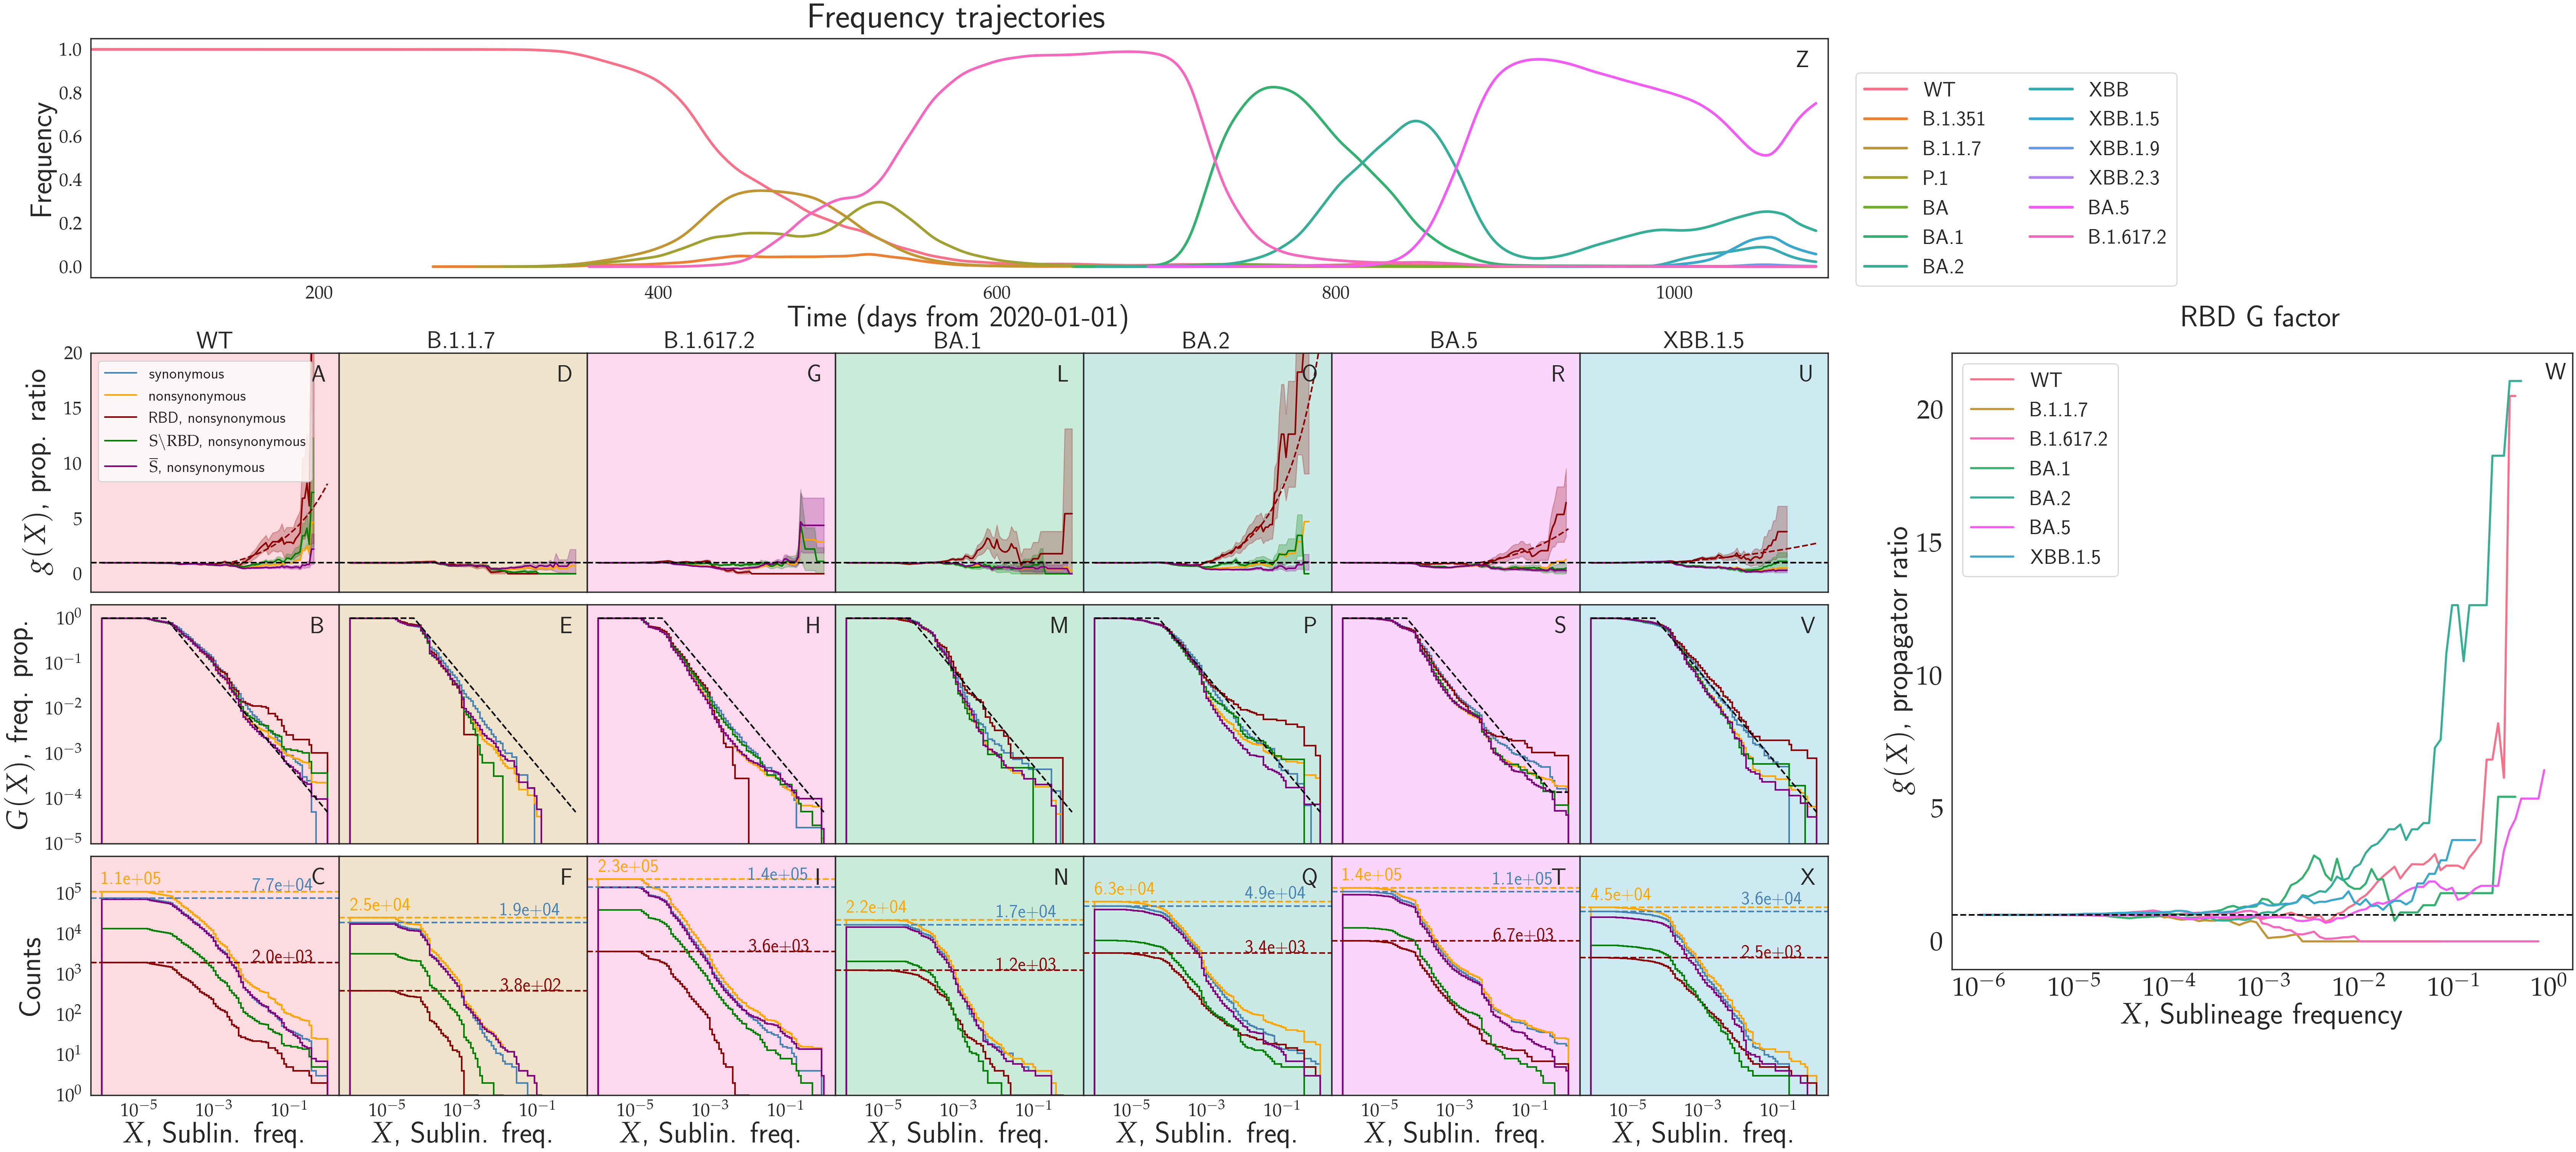

In [17]:
%autoreload

figure_mosaic = """
ZZZZZZZZZZZZZZ......
ZZZZZZZZZZZZZZ......
ZZZZZZZZZZZZZZ......
ZZZZZZZZZZZZZZ......
....................
AADDGGLLOORRUU.WWWWW
AADDGGLLOORRUU.WWWWW
AADDGGLLOORRUU.WWWWW
AADDGGLLOORRUU.WWWWW
BBEEHHMMPPSSVV.WWWWW
BBEEHHMMPPSSVV.WWWWW
BBEEHHMMPPSSVV.WWWWW
BBEEHHMMPPSSVV.WWWWW
CCFFIINNQQTTXX.WWWWW
CCFFIINNQQTTXX.WWWWW
CCFFIINNQQTTXX......
CCFFIINNQQTTXX......
"""
fig,ax= plt.subplot_mosaic(figure_mosaic, figsize=(1.2*10*len(new_summary_chuncks),1.2*30))

plt.subplots_adjust(wspace=0, hspace=0.25)

if True:
    axes_first_chunk = [ax['A'], ax['B'], ax['C']]
    axes_second_chunk = [ax['D'], ax['E'], ax['F']]
    axes_third_chunk = [ax['G'], ax['H'], ax['I']]
    axes_fourth_chunk = [ax['L'], ax['M'], ax['N']]
    axes_fifth_chunk = [ax['O'], ax['P'], ax['Q']]
    axes_sixth_chunk = [ax['R'], ax['S'], ax['T']]
    axes_seventh_chunk = [ax['U'], ax['V'], ax['X']]

axes_chunks = [axes_first_chunk, axes_second_chunk, axes_third_chunk, axes_fourth_chunk, axes_fifth_chunk, axes_sixth_chunk, axes_seventh_chunk]
# facecolor_chunks = ['steelblue', 'orangered', 'purple', 'green', 'slategrey']
if True:
    internal_axes = [ax['D'],ax['E'],ax['G'],ax['H'],ax['L'],ax['M'],ax['O'],ax['P'],ax['R'],ax['S'],ax['U'],ax['V']]
    #lower axes: c,f,i,n,q
    lower_axes = [ax['C'],ax['F'],ax['I'],ax['N'],ax['Q'],ax['T'],ax['X']]
    #left axes: a,b,c
    left_axes = [ax['A'],ax['B'],ax['C']]

    #first_row_axes = ADGLO
    first_row_axes = [ax['A'],ax['D'],ax['G'],ax['L'],ax['O'],ax['R'],ax['U']]

    #second_row_axes = BEHMP
    second_row_axes = [ax['B'],ax['E'],ax['H'],ax['M'],ax['P'],ax['S'],ax['V']]

    #third_row_axes = CFIQN
    third_row_axes = [ax['C'],ax['F'],ax['I'],ax['N'],ax['Q'],ax['T'],ax['X']]

sns.lineplot(
    data= global_time_series_df.query('day_diff < 1084'),
    x='day_diff',
    y='Freq',
    ax=ax['Z'], 
    hue= 'Pango_Variant',
    lw = 5)

#get the line color of every variant with more than 1e4 clades
lines_dict= {line.get_label():line.get_color() for line in ax['Z'].get_lines() if "_child" not in line.get_label()}
facecolor_chunks = [lines_dict[new_summary_chuncks[i].Pango_Variant.unique()[0]] for i in range(len(new_summary_chuncks)) if new_summary_chuncks[i].Pango_Variant.unique()[0] in lines_dict]

g_factors_chunks = []
for i in range(len(new_summary_chuncks)):
    pv = new_summary_chuncks[i].Pango_Variant.unique()[0]
    g_factors_chunks.append(ut.plot_column_chunk(new_summary_chuncks[i], axes_chunks[i], facecolor_chunks[i], plot_counts=True))
    plotlabel = f'{pv}'
    ax['W'].plot(g_factors_chunks[i][0], g_factors_chunks[i][1], color=facecolor_chunks[i],lw=4, label = plotlabel)
    # ax['W'].fill_between(g_factors_chunks[i][0], g_factors_chunks[i][1] - g_factors_chunks[i][2], g_factors_chunks[i][1] + g_factors_chunks[i][2], color=facecolor_chunks[i], alpha=0.2)



ax['A'].set_ylabel(r'$g(X)$, prop. ratio', fontsize=56, labelpad= 20)
# ax['B'].set_ylabel('inv. cumulative density',fontsize=46)
ax['B'].set_ylabel(r'$G(X)$, freq. prop.', fontsize=56, labelpad= 20)
ax['C'].set_ylabel('Counts',fontsize=56, labelpad= 20)

ax['Z'].legend(bbox_to_anchor=(1.01, .9), loc='upper left',fontsize=40, ncol = 2)

ax['Z'].set_xlim(left= 65, right=1090)
ax['Z'].set_title('Frequency trajectories', fontsize=66, pad =20)
ax['Z'].set_xlabel('Time (days from 2020-01-01)', fontsize=56)
ax['Z'].set_ylabel('Frequency', fontsize=56)

ax['W'].set_title('RBD G factor', pad= 50, fontsize=56)
ax['W'].set_xlabel('$X$, Sublineage frequency', fontsize=56)
ax['W'].set_ylabel(r'$g(X)$, propagator ratio', fontsize=56)
ax['W'].set_xscale('log')

ax['W'].axhline(1,color='black',linestyle='--')
ax['W'].legend(loc='best',fontsize=40)

for a in internal_axes:
    a.set_xticks([])
    a.set_yticks([])

for a in lower_axes[1:]:
    a.set_yticks([])
for a in left_axes[:-1]:
    a.set_xticks([])

for a in lower_axes:
    a.set_xlabel('$X$, Sublin. freq.',fontsize=56)


ylim_first_row = (np.min([a.get_ylim() for a in first_row_axes]), np.max([a.get_ylim() for a in first_row_axes]))
ylim_second_row = (np.min([a.get_ylim() for a in second_row_axes]), np.max([a.get_ylim() for a in second_row_axes]))    
ylim_third_row = (np.min([a.get_ylim() for a in third_row_axes]), np.max([a.get_ylim() for a in third_row_axes]))

for a in first_row_axes:
    a.set_ylim(ylim_first_row[0],20)
    a.axhline(1,color='black',linestyle='--')
for a in second_row_axes:
    a.set_ylim((1e-5,2))
for a in third_row_axes:
    a.set_ylim((1,ylim_third_row[1]*2))

# for i,t in enumerate(t_chunks):
#     if i>0:
#         ax['Z'].fill_betweenx((0,1), t_chunks[i-1], t_chunks[i], color=facecolor_chunks[i], alpha=0.25)
#         first_row_axes[i].set_title(f'{t_chunks[i-1]} < t < {t_chunks[i]}')
#     else:
#         print(i, facecolor_chunks[i])
#         ax['Z'].fill_betweenx((0,1), 0, t_chunks[i], color=facecolor_chunks[i], alpha=0.25)
#         first_row_axes[i].set_title(f't < {t_chunks[i]}')

for i in range(len(new_summary_chuncks)):
    first_row_axes[i].set_title(f'{new_summary_chuncks[i].Pango_Variant.unique()[0]}', fontsize=46)

handles = [Line2D([0], [0], color='steelblue', lw=3, label='synonymous'),
              Line2D([0], [0], color='orange', lw=3, label='nonsynonymous'),
              Line2D([0], [0], color='darkred', lw=3, label='RBD, nonsynonymous'),
              Line2D([0], [0], color='green', lw=3, linestyle='-', label=r'$\mathrm{S}\backslash\mathrm{RBD}$, nonsynonymous'),
              Line2D([0], [0], color='purple', lw=3, linestyle='-', label=r'$\overline{\mathrm{S}}$, nonsynonymous'),]

ax['A'].legend(handles=handles, loc='upper left',fontsize=30)

#annotate each ax, in the upper right corner
for a in ax:
    if a not in ['W','Z']:
        ax[a].annotate(a, (0.95, 0.95), xycoords='axes fraction', va='top', ha='right', fontsize=45)
    elif a == 'W':
        ax[a].annotate(a, (0.99, 0.95), xycoords='axes fraction', va='bottom', ha='right', fontsize=45)
    else:
        ax[a].annotate(a, (0.99, 0.95), xycoords='axes fraction', va='top', ha='right', fontsize=45)
    if a == 'W':
        ax[a].tick_params(axis='both', which='major', labelsize=50)        
    else:
        ax[a].tick_params(axis='both', which='major', labelsize=35)

# plt.savefig(thesis_picture_folder+'/fig5.pdf', bbox_inches='tight')
